# Week 6 Project

Jiwei Xia

In [16]:
# upload documents, run this only when using Google Colab
from google.colab import files
uploaded1 = files.upload()
uploaded2 = files.upload()
uploaded3 = files.upload()
uploaded4 = files.upload()
uploaded5 = files.upload()

Saving AAPL_Options.csv to AAPL_Options (1).csv


Saving DailyPrices.csv to DailyPrices.csv


Saving DailyReturn.csv to DailyReturn (1).csv


Saving problem3.csv to problem3 (1).csv


Saving risklib.py to risklib (1).py


In [2]:
# import packages
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from functools import partial
import risklib
import warnings
warnings.filterwarnings('ignore')

## Problem 1

Assume you a call and a put option with the following

* Current Stock Price $165
* Current Date 02/25/2022
* Options Expiration Date 03/18/2022
* Risk Free Rate of 0.25%
* Continuously Compounding Coupon of 0.53%

Calculate the time to maturity using calendar days (not trading days).

For a range of implied volatilities between 10% and 80%, plot the value of the call and the put.

Discuss these graphs. How does the supply and demand affect the implied volatility?

In [3]:
current_date = datetime(2022, 2, 25)
expire_date = datetime(2022, 3, 18)
T = (expire_date - current_date).days / 365
print("Time to maturity: " + str(T))

Time to maturity: 0.057534246575342465


In [4]:
def gbsm(option_type, S, X, T, sigma, r, b):
  '''
  option_type: call or put
  S: Underlying price
  X: Strike price
  T: Time to maturity
  sigma: Implied volatility
  r: Risk free rate
  b: Cost of carry
  '''
  d1 = (np.log(S / X) + (b + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
  d2 = d1 - sigma * np.sqrt(T)
  is_call = 1 if option_type == "Call" else -1

  res = is_call * (S * np.e ** ((b - r) * T) * \
                   scipy.stats.norm(0, 1).cdf(is_call * d1) \
                   - X * np.e ** (-r * T) * \
                   scipy.stats.norm(0, 1).cdf(is_call * d2))
    
  return res

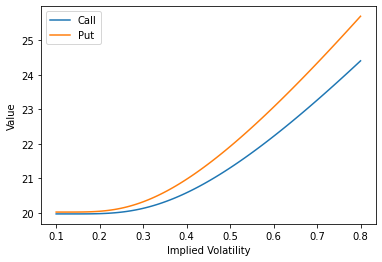

In [27]:
# Assume we pick strike price as 180 for put and 150 for call
X_put = 180
X_call = 150
S = 165

r = 0.0025
coupon = 0.0053
b = r - coupon

# For a range of implied volatilities between 10% and 80%
sigmas = np.linspace(0.1, 0.8, 100)

# Calculate the values for put and calls
call_values = []
put_values = []
for sigma in sigmas:
  call_values.append(gbsm("Call", S, S-20, T, sigma, r, b))
  put_values.append(gbsm("Put", S, S+20, T, sigma, r, b))

# Plot the result
plt.figure()
plt.plot(sigmas, call_values, label="Call")
plt.plot(sigmas, put_values, label="Put")
plt.xlabel("Implied Volatility")
plt.ylabel("Value")
plt.legend()
plt.show()

From the plot we can see that the values of the options rise with the implied volatilities. It is easy to understand that the increase in demand or decrease in supply for an option will cause its price to rise, and with the relationship we discovered above, it's clear that the implied volatility will move in same directions. 

That is to say:
* The increase in demand or decrease in supply for an option will cause its implied volatility to rise.
* The decrease in demand or increase in supply for an option will cause its implied volatility to fall.

## Problem 2

Use the options found in AAPL_Options.csv
* Current AAPL price is 164.85
* Current Date, Risk Free Rate and Dividend Rate are the same as problem #1.

Calculate the implied volatility for each option.

Plot the implied volatility vs the strike price for Puts and Calls. Discuss the shape of these graphs. What market dynamics could make these graphs?

There are bonus points available on this question based on your discussion. Take some time to research if needed.

In [6]:
def implied_vol(option_type, S, X, T, r, b, market_price, x0=0.5):
    def equation(sigma):
        return gbsm(option_type, S, X, T, sigma, r, b) - market_price
    # Back solve the Black-Scholes formula to get the implied volatility
    return scipy.optimize.fsolve(equation, x0=x0, xtol=0.00001)[0]

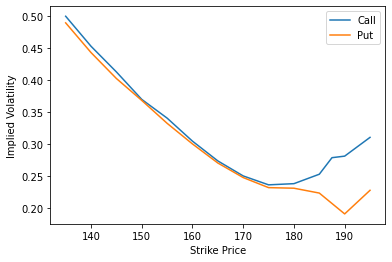

In [15]:
options = pd.read_csv("AAPL_Options.csv", parse_dates=["Expiration"])

S = 164.85

# Create lists to store the implied volatilities and strike prices for call and put
implied_vols_call = []
implied_vols_put = []
strike_prices_call = []
strike_prices_put = []

# Calculate the implied volatilities for each option
for i in range(len(options)):
  option_type = options["Type"][i]
  X = options["Strike"][i]
  T = (options["Expiration"][i] - current_date).days / 365
  market_price = options["Last Price"][i]
  sigma = implied_vol(option_type, S, X, T, r, b, market_price)
  if option_type == "Call":
    implied_vols_call.append(sigma)
    strike_prices_call.append(X)
  else:
    implied_vols_put.append(sigma)
    strike_prices_put.append(X)

# Plot the result
plt.figure()
plt.plot(strike_prices_call, implied_vols_call, label="Call")
plt.plot(strike_prices_put, implied_vols_put, label="Put")
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.legend()
plt.show()

From the plot we can see a clear pattern of how the implied volatility changes based on different strike prices. The pattern is typical and it's commonly known as a "Volatility Smile".

For a given expiration, options whose strike price differs substantially from the underlying asset's price command higher prices (and thus implied volatilities) than what is suggested by standard option pricing models. These options are said to be either deep in-the-money or out-of-the-money. And this kind of market dynamics could lead to the "Volatility Smile" pattern.

This anomaly implies deficiencies in the standard Black–Scholes option pricing model which assumes constant volatility and log-normal distributions of underlying asset returns. We can plot the actual distribution of the return and compare it with the lognormal distribution assumption.

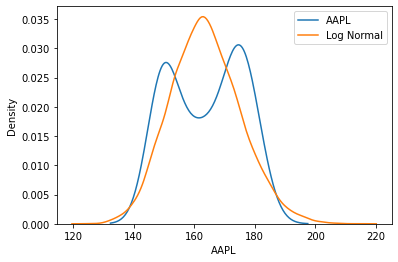

In [62]:
all_prices = pd.read_csv("DailyPrices.csv")
aapl_prices = all_prices['AAPL']

# Get the log of the apple prices
log_aapl_prices = np.log(aapl_prices)

# Simulate prices with log normal distribution assumption
mean = np.mean(log_aapl_prices)
std = np.std(log_aapl_prices)
np.random.seed(0)
log_normal_prices = scipy.stats.norm(mean, std).rvs(10000)

# Plot and compare the two
plt.figure()
sns.kdeplot(aapl_prices, label='AAPL')
sns.kdeplot(np.e**log_normal_prices, label='Log Normal')
plt.legend()
plt.show()

From the plot we can see that the actual distribution is very different from the log normal distribution assumption used by Black–Scholes method. This is one major reason for the "Volatility Smile" pattern.

## Problem 3

Use the portfolios found in problem3.csv
* Current AAPL price is 164.85
* Current Date, Risk Free Rate and Dividend Rate are the same as problem #1.

For each of the portfolios, graph the portfolio value over a range of underlying values. Plot the portfolio values and discuss the shapes. Bonus points available for tying these graphs to other topics discussed in the lecture.

Using DailyReturn.csv. Fit a Normal distribution to AAPL returns – assume 0 mean return. Simulate AAPL returns 10 days ahead and apply those returns to the current AAPL price (above). Calculate Mean, VaR and ES. Discuss.

Hints:
* you will need to calculate the implied volatility – not the same value as in #2
* you need to take into account the change in dates for option valuations. You are simulating
forward in time and options valuations are a function of time
* Calculate the PL from the current portfolio value using Current Date

In [9]:
def calculate_sim_values(portfolios, sim_prices, days_ahead=0):
  sim_values = pd.DataFrame(index=portfolios.index, 
                            columns=list(range(sim_prices.shape[0])))
  sim_prices = np.array(sim_prices)
  for i in portfolios.index:
    if portfolios["Type"][i] == "Stock":
      # For stock, the single value is its price
      single_values = sim_prices
    else:
      # For option, calculate values with gbsm method
      option_type = portfolios["OptionType"][i]
      S = sim_prices
      X = portfolios["Strike"][i]
      T = ((portfolios["ExpirationDate"][i] - current_date).days - days_ahead) / 365
      sigma = portfolios["ImpliedVol"][i]
      option_values = gbsm(option_type, S, X, T, sigma, r, b)
      single_values = option_values
    
    # Calculate the total values based on holding
    sim_values.loc[i, :] = portfolios["Holding"][i] * single_values
  
  # Combine the values for same portfolios
  sim_values['Portfolio'] = portfolios['Portfolio']
  return sim_values.groupby('Portfolio').sum()

In [10]:
portfolios = pd.read_csv("problem3.csv", parse_dates=["ExpirationDate"])

# Calculate the implied volatility for all portfolios
implied_vols = []
for i in range(len(portfolios.index)):
  option_type = portfolios["OptionType"][i]
  X = portfolios["Strike"][i]
  T = (portfolios["ExpirationDate"][i] - current_date).days / 365
  market_price = portfolios["CurrentPrice"][i]
  sigma = implied_vol(option_type, S, X, T, r, b, market_price)
  implied_vols.append(sigma)

# Store the implied volatility in portfolios
portfolios["ImpliedVol"] = implied_vols

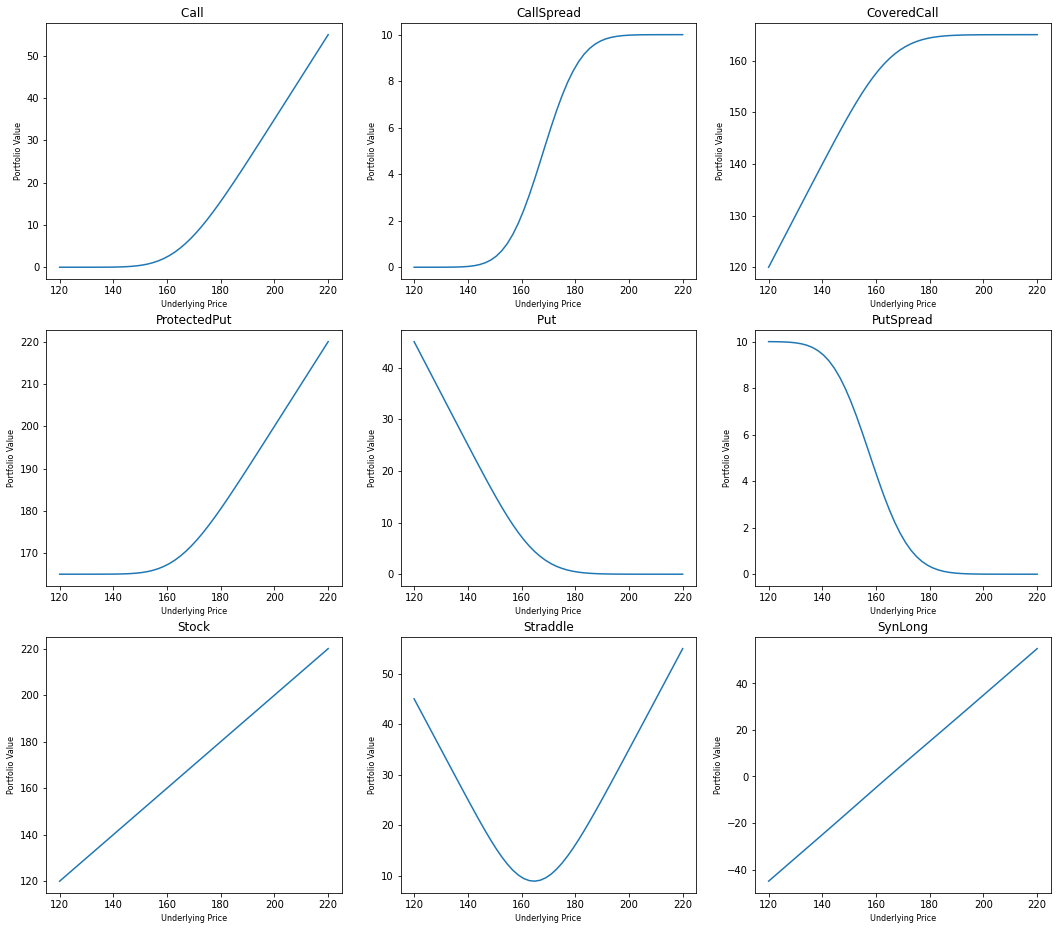

In [11]:
# Simulate the price in 120-220 range
sim_prices = np.linspace(120, 220, 50)

# Calculate the stock and option values
sim_values = calculate_sim_values(portfolios, sim_prices)

# Plot the values for each portfolio
fig, axes = plt.subplots(3, 3, figsize=(18, 16))
idx = 0
for portfolio, dataframe in sim_values.groupby('Portfolio'):
    i, j = idx // 3, idx % 3
    ax = axes[i][j]
    ax.plot(sim_prices, dataframe.iloc[0, :].values)
    ax.set_title(portfolio)
    ax.set_xlabel('Underlying Price', fontsize=8)
    ax.set_ylabel('Portfolio Value', fontsize=8)
    idx += 1

In [64]:
all_returns = pd.read_csv("DailyReturn.csv")

# Simulate the prices based on returns with normal distribution
std = all_returns['AAPL'].std()
np.random.seed(0)
sim_returns = scipy.stats.norm(0, std).rvs((10, 10000))
sim_prices = 164.85 * (1 + sim_returns).prod(axis=0)

# Calculate the current values and sim values
portfolios["CurrentValue"] = portfolios["CurrentPrice"] * portfolios["Holding"]
curr_values = portfolios.groupby('Portfolio')['CurrentValue'].sum()
sim_values = calculate_sim_values(portfolios, sim_prices, 10)

# Calculate the value difference
sim_value_changes = (sim_values.T - curr_values).T

# Calculate the Mean, VaR and ES, and print the results
result = pd.DataFrame(index=sim_value_changes.index)
result['Mean'] = sim_value_changes.mean(axis=1)
result['VaR'] = sim_value_changes.apply(lambda x:risklib.calculate_var(x, 0), axis=1)
result['ES'] = sim_value_changes.apply(lambda x:risklib.calculate_es(x), axis=1)
print(result)

                  Mean        VaR         ES
Portfolio                                   
Call          0.122743   4.349410   4.431032
CallSpread   -0.220995   3.629788   3.711144
CoveredCall  -0.084038   8.959942  12.038749
ProtectedPut  0.246862   4.129921   4.191795
Put           0.208157   4.243707   4.329090
PutSpread     0.359296   2.664595   2.738432
Stock         0.038705  13.309352  16.469782
Straddle      0.330900   2.443505   2.452159
SynLong      -0.085414  13.528841  16.709019


From the plots and data above, we can see that:

* For Call and Put: The basic options. Makes money as the stock price goes up or down. The risks are moderate.
* For CallSpread and PutSpread: They add a limit the the basic Call and Put. Lowering the risk by sacrificing returns.
* For CoveredCall and ProtectedPut: Basically a mix of stocks and options. The patterns are similar as Call or Put. The risks are also between stocks and options.
* For SynLong and Stock: SynLong has the same straightforward pattern as Stock, but with double returns. Both have high risks.
* Straddle: The most special portfolio here, since it makes money as long as the price moves regardless of the direction. The risk is low among all portfolios.

